# makemore - part 2
mlp

In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

dataset

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build the vocab and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:(i+1) for i,s in enumerate(chars)}; stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f'num of chars (and the special char .): {len(stoi)}')

num of chars (and the special char .): 27


dataset building:

given a name 'emma', we will add the following examples to the dataset:

```
X   ---> Y
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
```

In [5]:
def build_dataset(words):
    block_size = 3 # context length, which is the num of chars we take to predict the next char
    X, Y = [], []
    for w in words:
    #     print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
    #         print(context, ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# data split: 80, 10, 10
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## MLP
![](mlp_diagram.001.jpeg)

embedding (matrix C). we have 27 characters, and we will embed them into a 2 dim space, to start.

In [6]:
g = torch.Generator().manual_seed(2147483647)
# model params:
C = torch.randn((27,10), generator=g) # C will act as a look up table

# first hidden layer = linear layer: 6 -> 100
W1 = torch.randn((3*10, 200), generator=g)
b1 = torch.randn(200, generator=g)

# second (final) hidden layer = linear layer: 100 -> 27
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
print(f'num of params in the model: {sum(p.nelement() for p in parameters)}')

num of params in the model: 11897


example forward pass

In [39]:
# X (32, 3)
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp() # (32, 27)
# probs = counts / counts.sum(dim=1, keepdims=True) # (32, 27)
# loss = -probs[torch.arange(32), Y].log().mean()
# equivalent to cross entropy loss:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

training loop

trying to find the optimal learning rate (in a strange way):

In [122]:
lr_exp = torch.linspace(-3, 0, steps=1000)
lrs = 10**lr_exp
print(f'lrs are in a range from {min(lrs):.3f} to {max(lrs)}')

lrs are in a range from 0.001 to 1.0


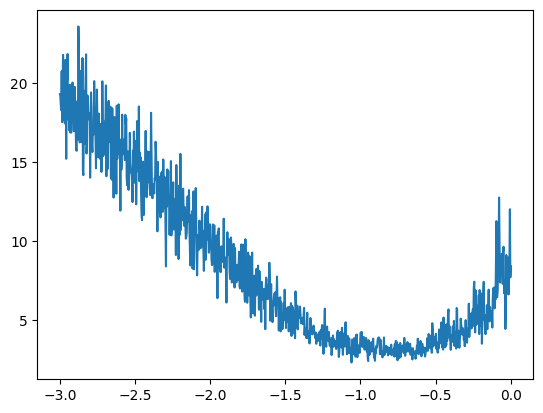

In [125]:
batch_size = 32
lri = []
lossi = []

# we start off with testing small lr, and move to larger lr.
for i in range(1000):
    
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
#     print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lr_exp[i])
    lossi.append(loss.item())

_ = plt.plot(lri, lossi)
    


we can see from the plot that around -1 is good. this means that the exp is -1, so the lr would be $10^{-1}$ = 0.1

In [200]:
# Training!
stepi = []
lossi = []

In [203]:
batch_size = 128

for i in range(200_000):
    
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(emb.shape[0], 3*10) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    stepi.append(i)
    lossi.append(loss.log10().item()) #log loss is less hockey stick like in the graph than just loss
    
    
# print(loss.item())


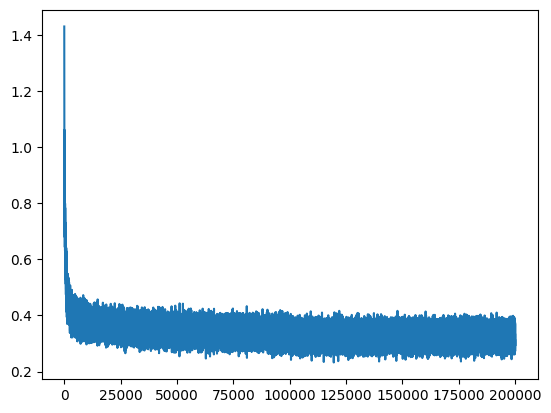

In [204]:
_ = plt.plot(stepi, lossi)

In [205]:
# calculate loss over the train set
emb = C[Xtr] 
h = torch.tanh(emb.view(emb.shape[0], 3*10) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.125417947769165

In [206]:
# calculate loss over the dev set
emb = C[Xdev] 
h = torch.tanh(emb.view(emb.shape[0], 3*10) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.163092851638794

embedding (C) visualization when dim of the embedding was 2

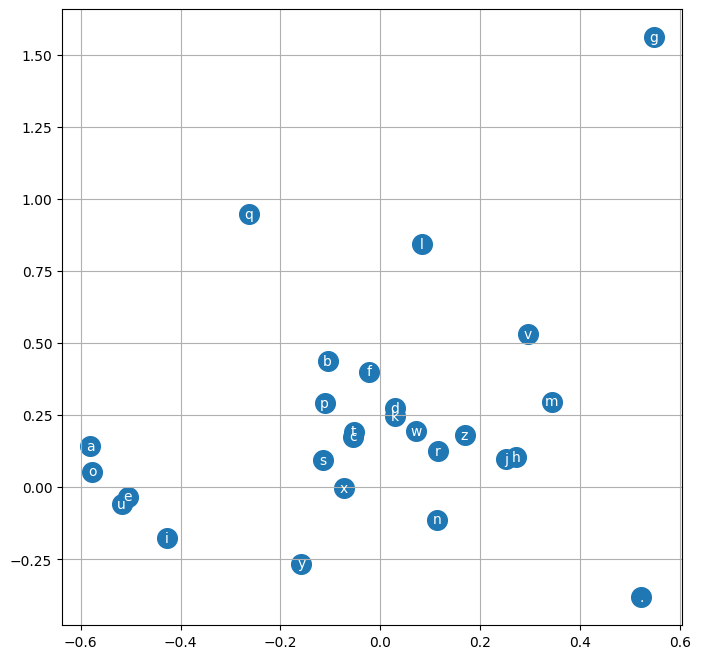

In [176]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

### Sampling from the model

In [212]:
for _ in range(20):
    out = []
    context = [0] * block_size # init . . .
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)[:-1])

stamedor
daya
muz
ana
sephuidrie
aley
perron
kellah
stelis
estas
apree
hardane
kazamarvex
kasai
benslynn
xakham
kion
yej
jaci
bresephmu
